In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries, get_common_combinations, get_df_with_combinations
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pickle

# Save Results

## Load mlflow runs

In [2]:
db_port = 5001
db_name = 'cohirf'
url = f'postgresql://belucci@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()
results_dir = Path.cwd().parent / 'results' / 'scale_features'
os.makedirs(results_dir, exist_ok=True)

In [3]:
experiment_names

['Default',
 'sfni-SpectralSubspaceRandomization',
 'sfni-KMeans',
 'sfni-BatchCoHiRF-SC-SRGF',
 'sfni-BatchCoHiRF-1iter',
 'sfni-CoHiRF',
 'sphere-BatchCoHiRF-DBSCAN-1iter',
 'sphere-DBSCAN',
 'sphere-CoHiRF-DBSCAN',
 'real-ari-BatchCoHiRF-1iter',
 'real-ari-AverageAgglomerativeClustering',
 'real-ari-BatchCoHiRF-DBSCAN-1iter',
 'real-ari-AffinityPropagation',
 'real-ari-BatchCoHiRF-SC-SRGF',
 'real-ari-CoHiRF-DBSCAN',
 'real-ari-CoHiRF-KernelRBF',
 'real-ari-CoHiRF',
 'real-ari-CompleteAgglomerativeClustering',
 'real-ari-DBSCAN',
 'real-ari-HDBSCAN',
 'real-ari-IRFLLRR',
 'real-ari-KMeans',
 'real-ari-MeanShift',
 'real-ari-OPTICS',
 'real-ari-Proclus',
 'real-ari-SingleAgglomerativeClustering',
 'real-ari-SpectralClustering',
 'real-ari-SpectralSubspaceRandomization',
 'real-ari-WardAgglomerativeClustering']

In [4]:
experiments_names = [exp for exp in experiment_names if exp.startswith('sfni')]

In [5]:
experiments_names

['sfni-SpectralSubspaceRandomization',
 'sfni-KMeans',
 'sfni-BatchCoHiRF-SC-SRGF',
 'sfni-BatchCoHiRF-1iter',
 'sfni-CoHiRF']

In [6]:
params_columns = [
    # "model_nickname",
    "model",
    "seed_model",
    "seed_dataset",
    "n_samples",
    "n_random",
    "n_informative",
    "n_features_dataset",
    "pct_random",
    "class_sep",
    # "seed_unified",
    "n_classes",
    "best/child_run_id",
]

In [7]:
latest_metrics_columns = [
    "fit_model_return_elapsed_time",
    # "best_n_clusters_",
    # "best_rand_score",
    # "best_adjusted_rand",
    # "best_mutual_info",
    # "best_adjusted_mutual_info",
    # "best_normalized_mutual_info",
    # "best_homogeneity_completeness_v_measure",
    # "best_silhouette",
    # "best_calinski_harabasz_score",
    # "best_davies_bouldin_score",
    # "best_inertia_score",
    # "best_homogeneity",
    # "best_completeness",
    # "best_v_measure",
    "best/n_clusters_",
    "best/rand_score",
    "best/adjusted_rand",
    "best/mutual_info",
    "best/adjusted_mutual_info",
    "best/normalized_mutual_info",
    "best/homogeneity_completeness_v_measure",
    "best/silhouette",
    "best/calinski_harabasz_score",
    # "best/davies_bouldin_score",
    # "best/inertia_score",
    "best/homogeneity",
    "best/completeness",
    "best/v_measure",
	"best/elapsed_time",
]

In [8]:
tags_columns = [
    'raised_exception',
    'EXCEPTION',
    'mlflow.parentRunId',
    # 'best_child_run_id',
]

In [9]:
# # parameters of each model, they are saved as tags for the parent run
# parameters = {
#     'RecursiveClustering': ['components_size', 'repetitions', 'kmeans_n_clusters'],
#     'KMeans': ['n_clusters'],
#     'HDBSCAN': ['min_cluster_size'],
#     'DBSCAN': ['eps', 'min_samples'],
#     'AffinityPropagation': ['damping'],
#     'OPTICS': ['min_samples'],
#     'SpectralSubspaceRandomization': ['n_similarities', 'sampling_ratio', 'sc_n_clusters'],
#     'WardAgglomerativeClustering': ['n_clusters'],
# }
# all_model_parameters = [p for model, params in parameters.items() for p in params]
# all_model_parameters = list(set(all_model_parameters))
# for param in all_model_parameters:
#     tags_columns.append(param)

In [10]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [11]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)


In [12]:
# df_runs_raw.loc[df_runs_raw.model_nickname.isna(), 'model_nickname'] = df_runs_raw.loc[df_runs_raw.model_nickname.isna(), 'model']
# df_runs_raw.loc[df_runs_raw.seed_unified.isna(), 'seed_unified'] = df_runs_raw.loc[df_runs_raw.seed_unified.isna(), 'seed_dataset']
# columns_best_ = [col for col in df_runs_raw.columns if col.startswith('best_')]
# for col in columns_best_:
# 	col_slash = col.replace('best_', 'best/')
# 	df_runs_raw.loc[df_runs_raw[col].isna(), col] = df_runs_raw.loc[df_runs_raw[col].isna(), col_slash]

In [13]:
df_runs_raw.to_csv(results_dir / 'df_runs_raw.csv', index=True)

In [14]:
df_runs_raw = pd.read_csv(results_dir / "df_runs_raw.csv", index_col=0)
df_runs_raw_parents = df_runs_raw.copy()
df_runs_raw_parents = df_runs_raw_parents.loc[df_runs_raw_parents['mlflow.parentRunId'].isna()]

In [15]:
df_runs_raw_parents

,status,start_time,end_time,best/child_run_id,class_sep,model,n_classes,n_features_dataset,n_informative,n_random,...,best/homogeneity,best/mutual_info,best/n_clusters_,best/normalized_mutual_info,best/rand_score,best/silhouette,best/v_measure,fit_model_return_elapsed_time,mlflow.parentRunId,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
0124c7658514474cb20555c6e64fb78a,FINISHED,1751650382613,1751650452465,860b255ec305490eb4d7b7c43295e11b,5.196152,BatchCoHiRF-1iter,5,NaN,3,100,...,0.948261,1.526167,122.0,0.571078,0.850438,-0.089212,0.571078,67.864262,NaN,False
01eca8c3d6e841a59a6a18914789b2bd,FINISHED,1751647665011,1751647717843,4a23f00309ca4b8d8526612bdf2ada64,5.196152,CoHiRF,5,NaN,3,100,...,1.000000,1.609438,5.0,1.000000,1.000000,0.184877,1.000000,49.950107,NaN,False
02342935ef274d998e1a1591b11313ec,FINISHED,1751909827280,1751909851989,b097d56595154fe388815e483556c4d1,5.196152,KMeans,5,NaN,3,10,...,1.000000,1.609438,7.0,0.936139,0.973325,0.455714,0.936139,17.669570,NaN,False
0317c4d0823443a48e14a63e8057e266,FINISHED,1751647350832,1751647368468,b91f2149bc4d44a1aa10b65ff0cbb498,5.196152,KMeans,5,NaN,3,1000,...,0.996174,1.603280,7.0,0.944723,0.977846,0.014801,0.944723,15.444865,NaN,False
0d1214cc35454d3c95b771ceaa67e4f3,FINISHED,1751648731820,1751649123895,9e3dfeed46d8466aa9849a9695d06dea,5.196152,SpectralSubspaceRandomization,5,NaN,3,10000,...,0.936747,1.507636,6.0,0.915188,0.979405,0.001817,0.915188,389.408431,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e3ee5bd6fb4a453790152feb27944530,FINISHED,1751647374647,1751647393252,909e92e2be65495d8d77f3a5dc7052cb,5.196152,KMeans,5,NaN,3,100,...,1.000000,1.609438,7.0,0.946640,0.977327,0.141674,0.946640,16.374399,NaN,False
e445909730e842be948031ac9e86d08a,FINISHED,1751647996098,1751648043052,d9d3e8f45892423291a89978766c3ce0,5.196152,KMeans,5,NaN,3,100,...,1.000000,1.609438,6.0,0.959057,0.980222,0.142363,0.959057,44.299211,NaN,False
eb504bfbf0a54925ad52f8e885b4c4da,FINISHED,1751647463622,1751647506706,2bc7c7601e4949d9bd513ca7b118bb65,5.196152,KMeans,5,NaN,3,10000,...,0.418166,0.673012,2.0,0.589728,0.679680,0.003960,0.589728,40.146560,NaN,False


## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [16]:
non_duplicate_columns = [
    # "model_nickname",
	"model",
    "seed_model",
    "seed_dataset",
    "n_samples",
    "n_random",
    "n_informative",
    "n_features_dataset",
    "pct_random",
    "class_sep",
    # "seed_unified",
    "n_classes",
]
df_runs_parents = df_runs_raw_parents.dropna(axis=0, how="all", subset=["best/adjusted_rand"]).copy()
df_runs_parents = df_runs_parents.loc[(~df_runs_parents.duplicated(non_duplicate_columns))]
# fill missing values with "None"
df_runs_parents = df_runs_parents.fillna("None")

# Missing

In [17]:
model_nickname = df_runs_parents['model'].unique().tolist()
model_nickname.sort()
model_nickname

['BatchCoHiRF-1iter',
 'BatchCoHiRF-SC-SRGF',
 'CoHiRF',
 'KMeans',
 'SpectralSubspaceRandomization']

In [18]:
model_nickname = [
    # "AffinityPropagation",
    # "AverageAgglomerativeClustering",
    # "BatchCoHiRF",
    "BatchCoHiRF-1iter",
    "BatchCoHiRF-SC-SRGF",
    # "Clique",
    "CoHiRF",
    # "CoHiRF-DBSCAN",
    # "CompleteAgglomerativeClustering",
    # "DBSCAN",
    # "HDBSCAN",
    # "IRFLLRR",
    "KMeans",
    # "KMeansProj",
    # "MeanShift",
    # "OPTICS",
    # "Proclus",
    # "SingleAgglomerativeClustering",
    # "SpectralClustering",
    "SpectralSubspaceRandomization",
    # "WardAgglomerativeClustering",
]

In [19]:
non_duplicate_columns = [
    "model",
    "n_random",
    "seed_dataset",
	"n_informative",
]

In [20]:
n_informative = [3]
n_random = [10, 100, 1000, 10000]
seed_dataset = [i for i in range(5)]
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_random, seed_dataset, n_informative]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)
# df_missing = df_missing.rename(columns={"seed_unified": "seeds_unified"})

In [21]:
df_missing

,model,n_random,seed_dataset,n_informative


In [22]:
df_runs_raw_parents

,status,start_time,end_time,best/child_run_id,class_sep,model,n_classes,n_features_dataset,n_informative,n_random,...,best/homogeneity,best/mutual_info,best/n_clusters_,best/normalized_mutual_info,best/rand_score,best/silhouette,best/v_measure,fit_model_return_elapsed_time,mlflow.parentRunId,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
0124c7658514474cb20555c6e64fb78a,FINISHED,1751650382613,1751650452465,860b255ec305490eb4d7b7c43295e11b,5.196152,BatchCoHiRF-1iter,5,NaN,3,100,...,0.948261,1.526167,122.0,0.571078,0.850438,-0.089212,0.571078,67.864262,NaN,False
01eca8c3d6e841a59a6a18914789b2bd,FINISHED,1751647665011,1751647717843,4a23f00309ca4b8d8526612bdf2ada64,5.196152,CoHiRF,5,NaN,3,100,...,1.000000,1.609438,5.0,1.000000,1.000000,0.184877,1.000000,49.950107,NaN,False
02342935ef274d998e1a1591b11313ec,FINISHED,1751909827280,1751909851989,b097d56595154fe388815e483556c4d1,5.196152,KMeans,5,NaN,3,10,...,1.000000,1.609438,7.0,0.936139,0.973325,0.455714,0.936139,17.669570,NaN,False
0317c4d0823443a48e14a63e8057e266,FINISHED,1751647350832,1751647368468,b91f2149bc4d44a1aa10b65ff0cbb498,5.196152,KMeans,5,NaN,3,1000,...,0.996174,1.603280,7.0,0.944723,0.977846,0.014801,0.944723,15.444865,NaN,False
0d1214cc35454d3c95b771ceaa67e4f3,FINISHED,1751648731820,1751649123895,9e3dfeed46d8466aa9849a9695d06dea,5.196152,SpectralSubspaceRandomization,5,NaN,3,10000,...,0.936747,1.507636,6.0,0.915188,0.979405,0.001817,0.915188,389.408431,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e3ee5bd6fb4a453790152feb27944530,FINISHED,1751647374647,1751647393252,909e92e2be65495d8d77f3a5dc7052cb,5.196152,KMeans,5,NaN,3,100,...,1.000000,1.609438,7.0,0.946640,0.977327,0.141674,0.946640,16.374399,NaN,False
e445909730e842be948031ac9e86d08a,FINISHED,1751647996098,1751648043052,d9d3e8f45892423291a89978766c3ce0,5.196152,KMeans,5,NaN,3,100,...,1.000000,1.609438,6.0,0.959057,0.980222,0.142363,0.959057,44.299211,NaN,False
eb504bfbf0a54925ad52f8e885b4c4da,FINISHED,1751647463622,1751647506706,2bc7c7601e4949d9bd513ca7b118bb65,5.196152,KMeans,5,NaN,3,10000,...,0.418166,0.673012,2.0,0.589728,0.679680,0.003960,0.589728,40.146560,NaN,False


In [23]:
# Join df_runs_raw_parents into df_missing using non_duplicate_columns to get the EXCEPTION column
df_missing_with_exception = df_missing.merge(
    df_runs_raw_parents[non_duplicate_columns + ["raised_exception"]],
    how="left",
    left_on=["model", "n_random", "seed_dataset", "n_informative"],
    right_on=["model", "n_random", "seed_dataset", "n_informative"],
)
df_missing_with_exception[["model", "n_random", "seed_dataset", "n_informative", "raised_exception"]]

,model,n_random,seed_dataset,n_informative,raised_exception
0,BatchCoHiRF-SC-SRGF,10,0,3,NaN
1,CoHiRF,10,0,3,NaN
2,KMeans,10,0,3,NaN
3,SpectralSubspaceRandomization,10,0,3,NaN
4,SpectralSubspaceRandomization,100,3,3,NaN
5,SpectralSubspaceRandomization,1000,2,3,NaN


In [56]:
df_missing["hpo_seed"] = df_missing["seed_dataset"]

In [57]:
missing_dict = {}
for model in df_missing['model'].unique():
	sub = df_missing[df_missing['model'] == model].drop(columns=['model'])
	missing_dict[model] = sub.to_dict(orient='records')
if len(missing_dict) != 0:
    with open(results_dir / 'missing_dict.pkl', 'wb') as f:
        pickle.dump(missing_dict, f)

In [58]:
missing_dict

{'BatchCoHiRF-SC-SRGF': [{'n_random': 10,
   'seed_dataset': 0,
   'n_informative': 3,
   'hpo_seed': 0}],
 'CoHiRF': [{'n_random': 10,
   'seed_dataset': 0,
   'n_informative': 3,
   'hpo_seed': 0}],
 'KMeans': [{'n_random': 10,
   'seed_dataset': 0,
   'n_informative': 3,
   'hpo_seed': 0}],
 'SpectralSubspaceRandomization': [{'n_random': 10,
   'seed_dataset': 0,
   'n_informative': 3,
   'hpo_seed': 0},
  {'n_random': 100, 'seed_dataset': 3, 'n_informative': 3, 'hpo_seed': 3},
  {'n_random': 1000, 'seed_dataset': 2, 'n_informative': 3, 'hpo_seed': 2}]}

# Get common combinations

In [23]:
model_nickname = [
    # "AffinityPropagation",
    # "AverageAgglomerativeClustering",
    # "BatchCoHiRF",
    "BatchCoHiRF-1iter",
    "BatchCoHiRF-SC-SRGF",
    # "Clique",
    "CoHiRF",
    # "CoHiRF-DBSCAN",
    # "CompleteAgglomerativeClustering",
    # "DBSCAN",
    # "HDBSCAN",
    # "IRFLLRR",
    "KMeans",
    # "KMeansProj",
    # "MeanShift",
    # "OPTICS",
    # "Proclus",
    # "SingleAgglomerativeClustering",
    # "SpectralClustering",
    "SpectralSubspaceRandomization",
    # "WardAgglomerativeClustering",
]
df = df_runs_parents.copy()
df = df.loc[df['model'].isin(model_nickname)]
column = 'model'
combination_columns = [
    "n_random",
    "seed_dataset",
    "n_informative",
]
common_combinations = get_common_combinations(df, column, combination_columns)

In [24]:
df_common = get_df_with_combinations(df, combination_columns, common_combinations)

In [25]:
df_common['n_samples'] = df_common['n_samples'].astype(int)
df_common['n_random'] = df_common['n_random'].astype(int)
df_common['n_informative'] = df_common['n_informative'].astype(int)

In [26]:
df_common

,status,start_time,end_time,best/child_run_id,class_sep,model,n_classes,n_features_dataset,n_informative,n_random,...,best/homogeneity,best/mutual_info,best/n_clusters_,best/normalized_mutual_info,best/rand_score,best/silhouette,best/v_measure,fit_model_return_elapsed_time,mlflow.parentRunId,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
0124c7658514474cb20555c6e64fb78a,FINISHED,1751650382613,1751650452465,860b255ec305490eb4d7b7c43295e11b,5.196152,BatchCoHiRF-1iter,5,None,3,100,...,0.948261,1.526167,122.0,0.571078,0.850438,-0.089212,0.571078,67.864262,None,False
01eca8c3d6e841a59a6a18914789b2bd,FINISHED,1751647665011,1751647717843,4a23f00309ca4b8d8526612bdf2ada64,5.196152,CoHiRF,5,None,3,100,...,1.000000,1.609438,5.0,1.000000,1.000000,0.184877,1.000000,49.950107,None,False
02342935ef274d998e1a1591b11313ec,FINISHED,1751909827280,1751909851989,b097d56595154fe388815e483556c4d1,5.196152,KMeans,5,None,3,10,...,1.000000,1.609438,7.0,0.936139,0.973325,0.455714,0.936139,17.669570,None,False
0317c4d0823443a48e14a63e8057e266,FINISHED,1751647350832,1751647368468,b91f2149bc4d44a1aa10b65ff0cbb498,5.196152,KMeans,5,None,3,1000,...,0.996174,1.603280,7.0,0.944723,0.977846,0.014801,0.944723,15.444865,None,False
0d1214cc35454d3c95b771ceaa67e4f3,FINISHED,1751648731820,1751649123895,9e3dfeed46d8466aa9849a9695d06dea,5.196152,SpectralSubspaceRandomization,5,None,3,10000,...,0.936747,1.507636,6.0,0.915188,0.979405,0.001817,0.915188,389.408431,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e3ee5bd6fb4a453790152feb27944530,FINISHED,1751647374647,1751647393252,909e92e2be65495d8d77f3a5dc7052cb,5.196152,KMeans,5,None,3,100,...,1.000000,1.609438,7.0,0.946640,0.977327,0.141674,0.946640,16.374399,None,False
e445909730e842be948031ac9e86d08a,FINISHED,1751647996098,1751648043052,d9d3e8f45892423291a89978766c3ce0,5.196152,KMeans,5,None,3,100,...,1.000000,1.609438,6.0,0.959057,0.980222,0.142363,0.959057,44.299211,None,False
eb504bfbf0a54925ad52f8e885b4c4da,FINISHED,1751647463622,1751647506706,2bc7c7601e4949d9bd513ca7b118bb65,5.196152,KMeans,5,None,3,10000,...,0.418166,0.673012,2.0,0.589728,0.679680,0.003960,0.589728,40.146560,None,False


# Plots

## HPO Time

/tmp/ipykernel_120005/3193468882.py:99: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


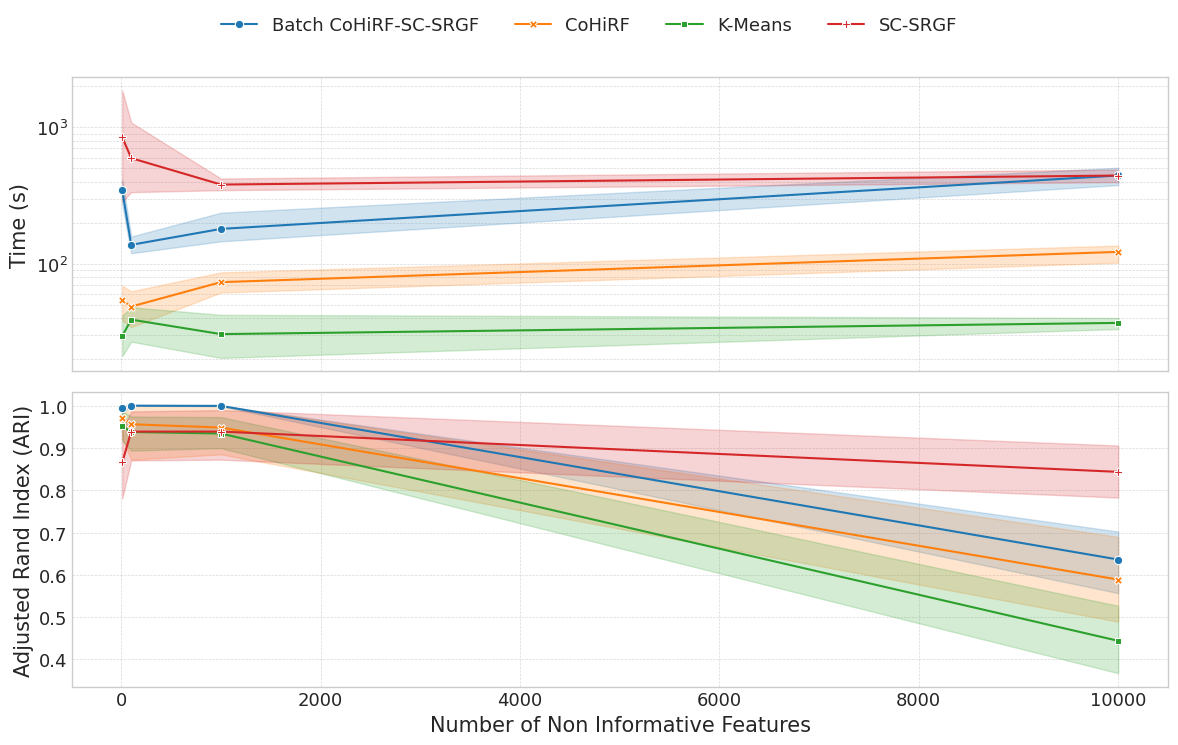

In [29]:
import matplotlib.ticker as mticker

df = df_common.copy()
n_informative = 3
n_samples = 1000
models_names = {
    # "AffinityPropagation": "Affinity Propagation",
    # "AverageAgglomerativeClustering": "Average Agglomerative Clustering",
    "CoHiRF": "CoHiRF",
    # "BatchCoHiRF-1iter": "Batch CoHiRF",
    "BatchCoHiRF-SC-SRGF": "Batch CoHiRF-SC-SRGF",
    # "CoHiRF-DBSCAN": "CoHiRF-DBSCAN",
    # "CompleteAgglomerativeClustering": "Complete Agglomerative Clustering",
    # "DBSCAN": "DBSCAN",
    # "HDBSCAN": "HDBSCAN",
    # "IRFLLRR": "IRFLLRR",
    "KMeans": "K-Means",
    # "OPTICS": "OPTICS",
    # "Proclus": "Proclus",
    # "SingleAgglomerativeClustering": "Single Agglomerative Clustering",
    # "SpectralClustering": "Spectral Clustering",
    "SpectralSubspaceRandomization": "SC-SRGF",
    # "WardAgglomerativeClustering": "Ward's Method",
}
df = df.loc[df["n_informative"] == n_informative]
df = df.loc[df["n_samples"] == n_samples]
df = df.loc[df["model"].isin(models_names.keys())]
df = df.replace({"model": models_names})
df = df.sort_values(by="model")
df = df.rename(
    columns={
        "fit_model_return_elapsed_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "n_random": "Number of Non Informative Features",
        "model": "Model",
        "best/adjusted_rand": "ARI",
    }
)

plt.style.use("seaborn-v0_8-whitegrid")
with mpl.rc_context(
    rc={
        "figure.constrained_layout.use": True,
        "savefig.bbox": "tight",
        "figure.figsize": (12, 7),
        "legend.loc": "upper left",
        "legend.frameon": True,
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.grid": True,
        "grid.color": "grey",
        "grid.alpha": 0.3,
    }
):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs = axs.flatten()
    palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
    # Time plot
    ax = sns.lineplot(
        data=df,
        x="Number of Non Informative Features",
        y="Time (s)",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[0],
        palette=palette,
    )
    ax.set_yscale("log")
    ax.set_ylabel("Time (s)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ARI plot
    ax2 = sns.lineplot(
        data=df,
        x="Number of Non Informative Features",
        y="ARI",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[1],
        palette=palette,
    )
    ax2.set_ylabel("Adjusted Rand Index (ARI)")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
    ax.get_legend().remove()
    ax2.get_legend().remove()
    plt.xlabel("Number of Non Informative Features")
    plt.tight_layout()
    # plt.subplots_adjust(top=0.88)
    plt.savefig(
        results_dir / f"hpo_non_informative_features_n-informative_{n_informative}_n-samples_{n_samples}_all.pdf", dpi=300
    )
    plt.show()

In [31]:
df

,status,start_time,end_time,best/child_run_id,class_sep,Model,n_classes,n_features_dataset,n_informative,Number of Non Informative Features,...,best/homogeneity,best/mutual_info,best/n_clusters_,best/normalized_mutual_info,best/rand_score,best/silhouette,best/v_measure,Time (s),mlflow.parentRunId,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
ffd53965d3ed42d9aba58b670ae9f164,FINISHED,1751647440224,1751647657778,80fee66362f742348d21e97ae7e1b8d6,5.196152,Batch CoHiRF,5,None,3,1000,...,0.616068,0.991524,24.0,0.478455,0.833061,-0.013904,0.478455,215.013696,None,False
76fff658f7304f719e901d1dc91247a2,FINISHED,1751650287045,1751650375147,74120dd097d643c199c8fe727ae8e764,5.196152,Batch CoHiRF,5,None,3,10,...,0.992537,1.597426,169.0,0.548543,0.829916,-0.216296,0.548543,85.899787,None,False
569fab38765f48859e79fd138b6ab67c,FINISHED,1751648552425,1751648640807,3e187aeff4644a4b966d4098ac5ac5c5,5.196152,Batch CoHiRF,5,None,3,100,...,0.929954,1.496703,80.0,0.604119,0.862839,-0.075629,0.604119,85.665683,None,False
534e368b3a4a4bb28e076aba54e2234a,FINISHED,1751648368108,1751648905539,8d64fab039f94fcaaf37e102f8842577,5.196152,Batch CoHiRF,5,None,3,10000,...,0.117943,0.189823,50.0,0.081924,0.762372,-0.010498,0.081924,533.125710,None,False
41ee8fb6e2b14fe99b03c57796325509,FINISHED,1751649177456,1751649424485,23a80f28a0d24c789be0ae8a92cad509,5.196152,Batch CoHiRF,5,None,3,1000,...,0.575535,0.926288,18.0,0.494842,0.812599,-0.014617,0.494842,244.357412,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2d4da1eeb5d249fc83256b9438ec3ed5,FINISHED,1751650134824,1751650493674,6eb3d7e55f4645f390bd8d0155759fa8,5.196152,SC-SRGF,5,None,3,100,...,0.982357,1.581042,8.0,0.881279,0.947177,0.073243,0.881279,356.818629,None,False
409a6a320cb94fb0ae333744b849cac1,FINISHED,1751649878653,1751650125822,25f6df882f524c1db9ada2482b705c65,5.196152,SC-SRGF,5,None,3,10,...,1.000000,1.609438,7.0,0.928754,0.965824,0.364639,0.928754,244.910764,None,False
8adde700bcd747c9b091e995e1c0de4e,FINISHED,1751649128743,1751649608965,a5aef18b0b474f1693869ee9361b1dc2,5.196152,SC-SRGF,5,None,3,10000,...,0.833706,1.341798,6.0,0.797471,0.935742,0.001628,0.797471,477.687206,None,False


In [32]:
import matplotlib.ticker as mticker

df = df_common.copy()
n_informative = 3
n_samples = 1000
models_names = {
    # "AffinityPropagation": "Affinity Propagation",
    # "AverageAgglomerativeClustering": "Average Agglomerative Clustering",
    "CoHiRF": "CoHiRF",
    # "CoHiRF-DBSCAN": "CoHiRF-DBSCAN",
    "CompleteAgglomerativeClustering": "Complete Agglomerative Clustering",
    # "DBSCAN": "DBSCAN",
    # "HDBSCAN": "HDBSCAN",
    # "IRFLLRR": "IRFLLRR",
    "KMeans": "K-Means",
    # "OPTICS": "OPTICS",
    # "Proclus": "Proclus",
    # "SingleAgglomerativeClustering": "Single Agglomerative Clustering",
    # "SpectralClustering": "Spectral Clustering",
    "SpectralSubspaceRandomization": "SC-SRGF",
    "WardAgglomerativeClustering": "Ward's Method",
}
df = df.loc[df["n_informative"] == n_informative]
df = df.loc[df["n_samples"] == n_samples]
df = df.loc[df["model_nickname"].isin(models_names.keys())]
df = df.replace({"model_nickname": models_names})
df = df.sort_values(by="model_nickname")
df = df.rename(
    columns={
        "fit_model_return_elapsed_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "n_random": "Number of Non Informative Features",
        "model_nickname": "Model",
        "best_adjusted_rand": "ARI",
    }
)

plt.style.use("seaborn-v0_8-whitegrid")
with mpl.rc_context(
    rc={
        "figure.constrained_layout.use": True,
        "savefig.bbox": "tight",
        "figure.figsize": (12, 7),
        "legend.loc": "upper left",
        "legend.frameon": True,
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.grid": True,
        "grid.color": "grey",
        "grid.alpha": 0.3,
    }
):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs = axs.flatten()
    palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
    # Time plot
    ax = sns.lineplot(
        data=df,
        x="Number of Non Informative Features",
        y="Time (s)",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[0],
        palette=palette,
    )
    ax.set_yscale("log")
    ax.set_ylabel("Time (s)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ARI plot
    ax2 = sns.lineplot(
        data=df,
        x="Number of Non Informative Features",
        y="ARI",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[1],
        palette=palette,
    )
    ax2.set_ylabel("Adjusted Rand Index (ARI)")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
    ax.get_legend().remove()
    ax2.get_legend().remove()
    plt.xlabel("Number of Non Informative Features")
    plt.tight_layout()
    plt.savefig(results_dir / f"hpo_non_informative_features_n-informative_{n_informative}_n-samples_{n_samples}.pdf", dpi=300)
    plt.show()

KeyError: 'model_nickname'

In [33]:
import matplotlib.ticker as mticker

df = df_common.copy()
n_informative = 3
n_samples = 1000
models_names = {
    # "AffinityPropagation": "Affinity Propagation",
    # "AverageAgglomerativeClustering": "Average Agglomerative Clustering",
    "CoHiRF": "CoHiRF",
    "BatchCoHiRF-SC-SRGF": "Batch CoHiRF-SC-SRGF",
    # "CoHiRF-DBSCAN": "CoHiRF-DBSCAN",
    # "CompleteAgglomerativeClustering": "Complete Agglomerative Clustering",
    # "DBSCAN": "DBSCAN",
    # "HDBSCAN": "HDBSCAN",
    # "IRFLLRR": "IRFLLRR",
    "KMeans": "K-Means",
    # "OPTICS": "OPTICS",
    # "Proclus": "Proclus",
    # "SingleAgglomerativeClustering": "Single Agglomerative Clustering",
    # "SpectralClustering": "Spectral Clustering",
    "SpectralSubspaceRandomization": "SC-SRGF",
    # "WardAgglomerativeClustering": "Ward's Method",
}
df = df.loc[df["n_informative"] == n_informative]
df = df.loc[df["n_samples"] == n_samples]
df = df.loc[df["model_nickname"].isin(models_names.keys())]
df = df.replace({"model_nickname": models_names})
df = df.sort_values(by="model_nickname")
df = df.rename(
    columns={
        "fit_model_return_elapsed_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "n_random": "Number of Non Informative Features",
        "model_nickname": "Model",
        "best_adjusted_rand": "ARI",
    }
)

plt.style.use("seaborn-v0_8-whitegrid")
with mpl.rc_context(
    rc={
        "figure.constrained_layout.use": True,
        "savefig.bbox": "tight",
        "figure.figsize": (12, 7),
        "legend.loc": "upper left",
        "legend.frameon": True,
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.grid": True,
        "grid.color": "grey",
        "grid.alpha": 0.3,
    }
):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs = axs.flatten()
    palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
    # Time plot
    ax = sns.lineplot(
        data=df,
        x="Number of Non Informative Features",
        y="Time (s)",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[0],
        palette=palette,
    )
    ax.set_yscale("log")
    ax.set_ylabel("Time (s)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ARI plot
    ax2 = sns.lineplot(
        data=df,
        x="Number of Non Informative Features",
        y="ARI",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[1],
        palette=palette,
    )
    ax2.set_ylabel("Adjusted Rand Index (ARI)")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
    ax.get_legend().remove()
    ax2.get_legend().remove()
    plt.xlabel("Number of Non Informative Features")
    plt.tight_layout()
    plt.savefig(
        results_dir / f"hpo_non_informative_features_n-informative_{n_informative}_n-samples_{n_samples}_only_cohirf.pdf", dpi=300
    )
    plt.show()

KeyError: 'model_nickname'

## Best Time

/tmp/ipykernel_120005/3809881235.py:99: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


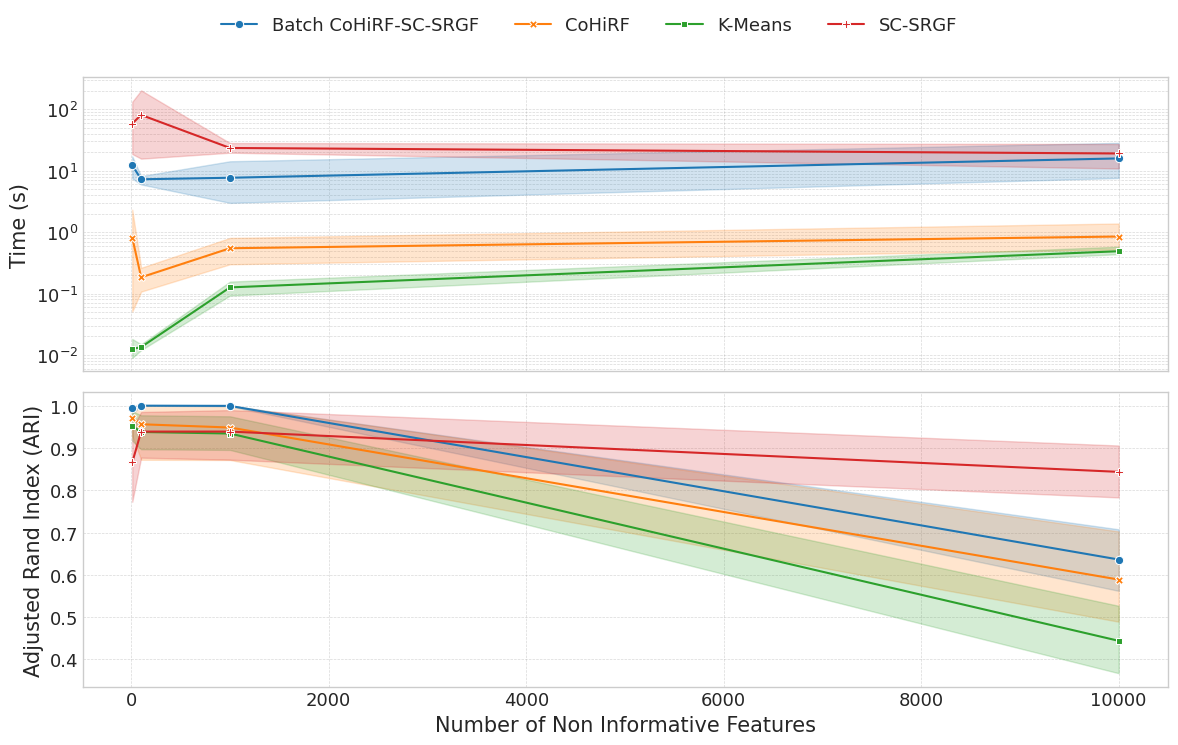

In [30]:
import matplotlib.ticker as mticker

df = df_common.copy()
n_informative = 3
n_samples = 1000
models_names = {
    # "AffinityPropagation": "Affinity Propagation",
    # "AverageAgglomerativeClustering": "Average Agglomerative Clustering",
    "CoHiRF": "CoHiRF",
    # "BatchCoHiRF-1iter": "Batch CoHiRF",
    "BatchCoHiRF-SC-SRGF": "Batch CoHiRF-SC-SRGF",
    # "CoHiRF-DBSCAN": "CoHiRF-DBSCAN",
    # "CompleteAgglomerativeClustering": "Complete Agglomerative Clustering",
    # "DBSCAN": "DBSCAN",
    # "HDBSCAN": "HDBSCAN",
    # "IRFLLRR": "IRFLLRR",
    "KMeans": "K-Means",
    # "OPTICS": "OPTICS",
    # "Proclus": "Proclus",
    # "SingleAgglomerativeClustering": "Single Agglomerative Clustering",
    # "SpectralClustering": "Spectral Clustering",
    "SpectralSubspaceRandomization": "SC-SRGF",
    # "WardAgglomerativeClustering": "Ward's Method",
}
df = df.loc[df["n_informative"] == n_informative]
df = df.loc[df["n_samples"] == n_samples]
df = df.loc[df["model"].isin(models_names.keys())]
df = df.replace({"model": models_names})
df = df.sort_values(by="model")
df = df.rename(
    columns={
        "best/elapsed_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "n_random": "Number of Non Informative Features",
        "model": "Model",
        "best/adjusted_rand": "ARI",
    }
)

plt.style.use("seaborn-v0_8-whitegrid")
with mpl.rc_context(
    rc={
        "figure.constrained_layout.use": True,
        "savefig.bbox": "tight",
        "figure.figsize": (12, 7),
        "legend.loc": "upper left",
        "legend.frameon": True,
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.grid": True,
        "grid.color": "grey",
        "grid.alpha": 0.3,
    }
):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs = axs.flatten()
    palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
    # Time plot
    ax = sns.lineplot(
        data=df,
        x="Number of Non Informative Features",
        y="Time (s)",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[0],
        palette=palette,
    )
    ax.set_yscale("log")
    ax.set_ylabel("Time (s)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ARI plot
    ax2 = sns.lineplot(
        data=df,
        x="Number of Non Informative Features",
        y="ARI",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[1],
        palette=palette,
    )
    ax2.set_ylabel("Adjusted Rand Index (ARI)")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
    ax.get_legend().remove()
    ax2.get_legend().remove()
    plt.xlabel("Number of Non Informative Features")
    plt.tight_layout()
    plt.savefig(
        results_dir / f"best_non_informative_features_n-informative_{n_informative}_n-samples_{n_samples}.pdf", dpi=300
    )
    plt.show()

/tmp/ipykernel_5451/3962678554.py:98: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


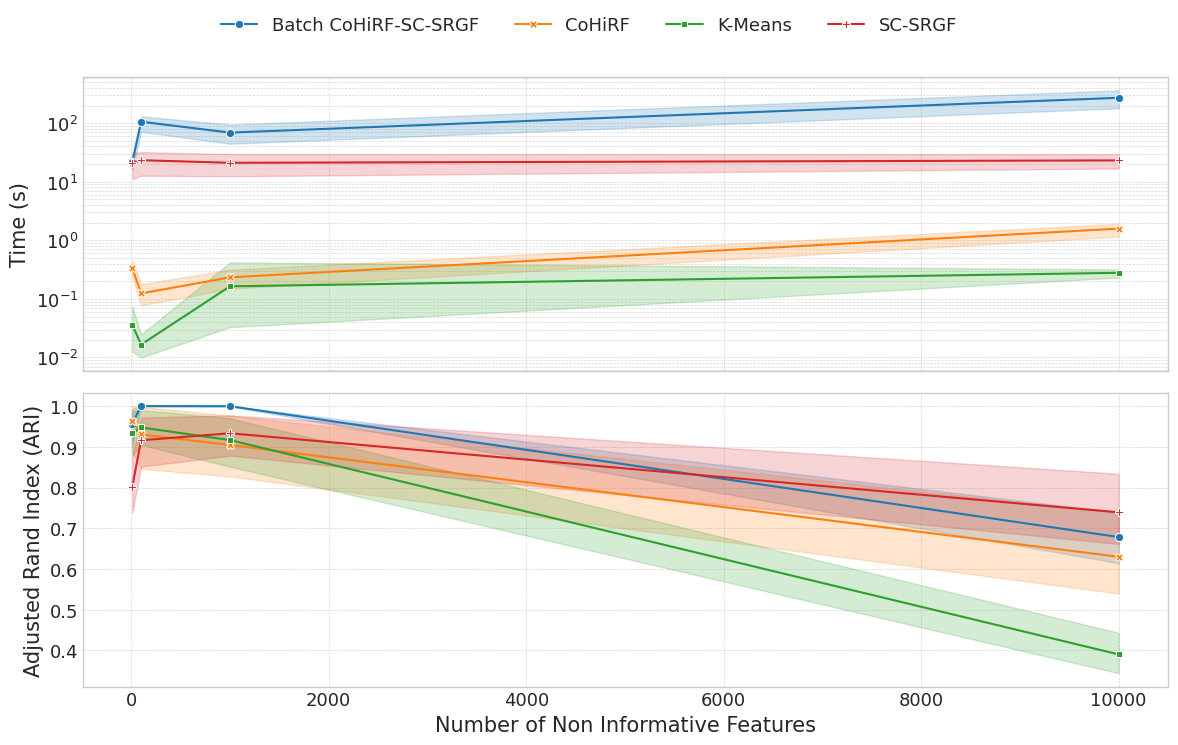

In [39]:
import matplotlib.ticker as mticker

df = df_common.copy()
n_informative = 3
n_samples = 1000
models_names = {
    # "AffinityPropagation": "Affinity Propagation",
    # "AverageAgglomerativeClustering": "Average Agglomerative Clustering",
    "CoHiRF": "CoHiRF",
    "BatchCoHiRF-SC-SRGF": "Batch CoHiRF-SC-SRGF",
    # "CoHiRF-DBSCAN": "CoHiRF-DBSCAN",
    # "CompleteAgglomerativeClustering": "Complete Agglomerative Clustering",
    # "DBSCAN": "DBSCAN",
    # "HDBSCAN": "HDBSCAN",
    # "IRFLLRR": "IRFLLRR",
    "KMeans": "K-Means",
    # "OPTICS": "OPTICS",
    # "Proclus": "Proclus",
    # "SingleAgglomerativeClustering": "Single Agglomerative Clustering",
    # "SpectralClustering": "Spectral Clustering",
    "SpectralSubspaceRandomization": "SC-SRGF",
    # "WardAgglomerativeClustering": "Ward's Method",
}
df = df.loc[df["n_informative"] == n_informative]
df = df.loc[df["n_samples"] == n_samples]
df = df.loc[df["model_nickname"].isin(models_names.keys())]
df = df.replace({"model_nickname": models_names})
df = df.sort_values(by="model_nickname")
df = df.rename(
    columns={
        "best_child_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "n_random": "Number of Non Informative Features",
        "model_nickname": "Model",
        "best_adjusted_rand": "ARI",
    }
)

plt.style.use("seaborn-v0_8-whitegrid")
with mpl.rc_context(
    rc={
        "figure.constrained_layout.use": True,
        "savefig.bbox": "tight",
        "figure.figsize": (12, 7),
        "legend.loc": "upper left",
        "legend.frameon": True,
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.grid": True,
        "grid.color": "grey",
        "grid.alpha": 0.3,
    }
):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs = axs.flatten()
    palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
    # Time plot
    ax = sns.lineplot(
        data=df,
        x="Number of Non Informative Features",
        y="Time (s)",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[0],
        palette=palette,
    )
    ax.set_yscale("log")
    ax.set_ylabel("Time (s)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ARI plot
    ax2 = sns.lineplot(
        data=df,
        x="Number of Non Informative Features",
        y="ARI",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[1],
        palette=palette,
    )
    ax2.set_ylabel("Adjusted Rand Index (ARI)")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
    ax.get_legend().remove()
    ax2.get_legend().remove()
    plt.xlabel("Number of Non Informative Features")
    plt.tight_layout()
    plt.savefig(
        results_dir / f"best_non_informative_features_n-informative_{n_informative}_n-samples_{n_samples}_only_cohirf.pdf", dpi=300
    )
    plt.show()

/tmp/ipykernel_180745/3722283627.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


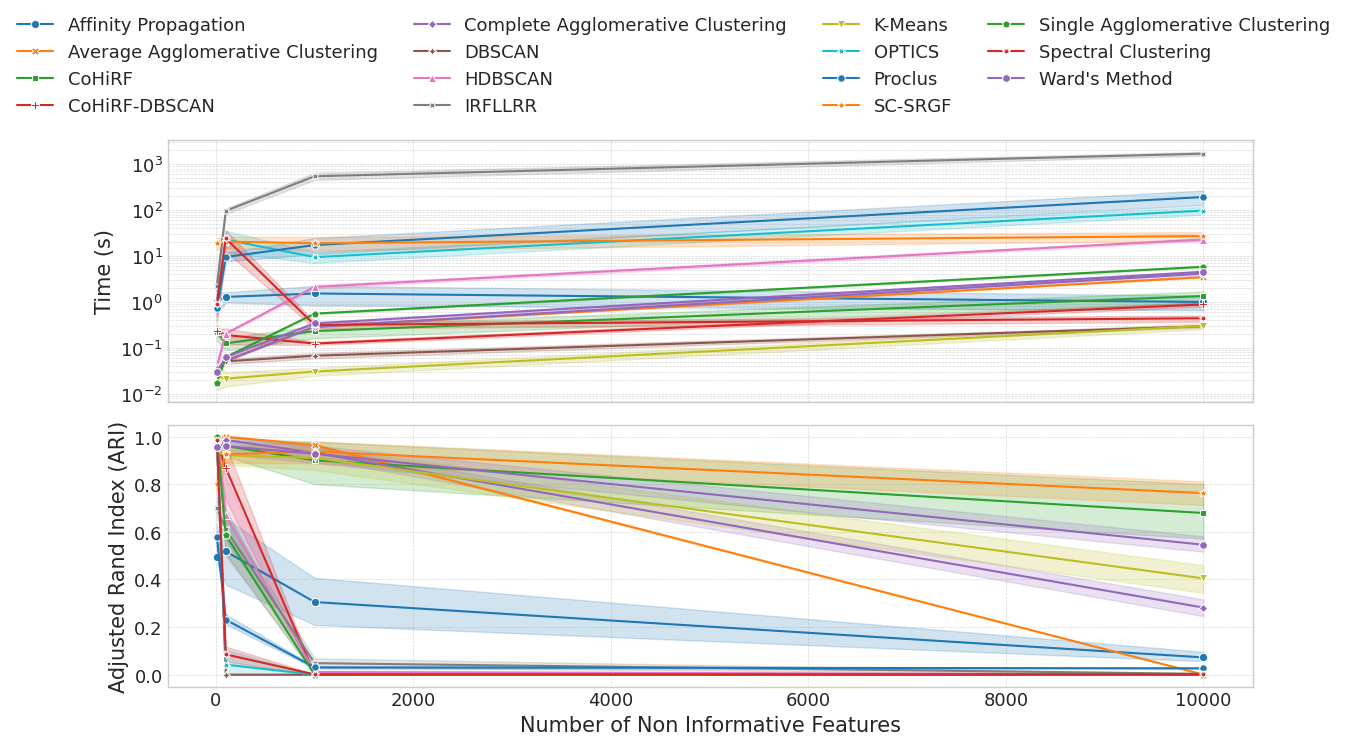

In [41]:
import matplotlib.ticker as mticker

df = df_common.copy()
n_informative = 3
n_samples = 1000
models_names = {
    "AffinityPropagation": "Affinity Propagation",
    "AverageAgglomerativeClustering": "Average Agglomerative Clustering",
    "CoHiRF": "CoHiRF",
    "CoHiRF-DBSCAN": "CoHiRF-DBSCAN",
    "CompleteAgglomerativeClustering": "Complete Agglomerative Clustering",
    "DBSCAN": "DBSCAN",
    "HDBSCAN": "HDBSCAN",
    "IRFLLRR": "IRFLLRR",
    "KMeans": "K-Means",
    "OPTICS": "OPTICS",
    "Proclus": "Proclus",
    "SingleAgglomerativeClustering": "Single Agglomerative Clustering",
    "SpectralClustering": "Spectral Clustering",
    "SpectralSubspaceRandomization": "SC-SRGF",
    "WardAgglomerativeClustering": "Ward's Method",
}
df = df.loc[df["n_informative"] == n_informative]
df = df.loc[df["n_samples"] == n_samples]
df = df.loc[df["model_nickname"].isin(models_names.keys())]
df = df.replace({"model_nickname": models_names})
df = df.sort_values(by="model_nickname")
df = df.rename(
    columns={
        "best_child_time": "Time (s)",
        "max_memory_used": "Memory (MB)",
        "n_samples": "Number of samples",
        "n_random": "Number of Non Informative Features",
        "model_nickname": "Model",
        "best_adjusted_rand": "ARI",
    }
)

plt.style.use("seaborn-v0_8-whitegrid")
with mpl.rc_context(
    rc={
        "figure.constrained_layout.use": True,
        "savefig.bbox": "tight",
        "figure.figsize": (12, 7),
        "legend.loc": "upper left",
        "legend.frameon": True,
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.grid": True,
        "grid.color": "grey",
        "grid.alpha": 0.3,
    }
):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs = axs.flatten()
    palette = sns.color_palette("tab10", n_colors=len(df["Model"].unique()))
    # Time plot
    ax = sns.lineplot(
        data=df,
        x="Number of Non Informative Features",
        y="Time (s)",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[0],
        palette=palette,
    )
    ax.set_yscale("log")
    ax.set_ylabel("Time (s)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    # ARI plot
    ax2 = sns.lineplot(
        data=df,
        x="Number of Non Informative Features",
        y="ARI",
        hue="Model",
        style="Model",
        markers=True,
        dashes=False,
        errorbar="ci",
        ax=axs[1],
        palette=palette,
    )
    ax2.set_ylabel("Adjusted Rand Index (ARI)")
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=13, frameon=False, bbox_to_anchor=(0.5, 1.08))
    ax.get_legend().remove()
    ax2.get_legend().remove()
    plt.xlabel("Number of Non Informative Features")
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.savefig(
        results_dir / f"best_non_informative_features_n-informative_{n_informative}_n-samples_{n_samples}_all.pdf",
        dpi=300,
    )
    plt.show()

## Save Dataframe

In [80]:
df = df_common.copy()
n_informative = 3
n_samples = 1000
models_names = {
    "AffinityPropagation": "Affinity Propagation",
    "AverageAgglomerativeClustering": "Average Agglomerative Clustering",
    "CoHiRF": "CoHiRF",
    "CoHiRF-DBSCAN": "CoHiRF-DBSCAN",
    "CompleteAgglomerativeClustering": "Complete Agglomerative Clustering",
    "DBSCAN": "DBSCAN",
    "HDBSCAN": "HDBSCAN",
    "IRFLLRR": "IRFLLRR",
    "KMeans": "K-Means",
    "OPTICS": "OPTICS",
    "Proclus": "Proclus",
    "SingleAgglomerativeClustering": "Single Agglomerative Clustering",
    "SpectralClustering": "Spectral Clustering",
    "SpectralSubspaceRandomization": "SC-SRGF",
    "WardAgglomerativeClustering": "Ward's Method",
}
df = df.loc[df["n_informative"] == n_informative]
df = df.loc[df["n_samples"] == n_samples]
df = df.loc[df["model_nickname"].isin(models_names.keys())]
df = df.replace({"model_nickname": models_names})
df = df.sort_values(by="model_nickname")
columns_rename = {
    "fit_model_return_elapsed_time": "HPO Time (s)",
    "best_child_time": "Best Time (s)",
    "n_samples": "Number of Samples",
    "n_informative": "Number of Informative Features",
    "n_random": "Number of Non-Informative Features",
    "n_classes": "Number of Classes",
    "model_nickname": "Model",
    "seed_unified": "Seed",
    "best_rand_score": "Rand Score",
    "best_adjusted_rand": "Adjusted Rand Index (ARI)",
    "best_mutual_info": "Mutual Information (MI)",
    "best_adjusted_mutual_info": "Adjusted Mutual Information (AMI)",
    "best_normalized_mutual_info": "Normalized Mutual Information (NMI)",
    "best_silhouette": "Silhouette Score",
    "best_calinski_harabasz_score": "Calinski-Harabasz Score",
    "best_davies_bouldin_score": "Davies-Bouldin Score",
    "best_inertia_score": "Inertia Score",
    "best_homogeneity": "Homogeneity",
    "best_completeness": "Completeness",
    "best_v_measure": "V-Measure",
}
df = df.rename(columns=columns_rename)
df = df[columns_rename.values()]
df.to_csv(results_dir / f"raw_data.csv", index=False)
# Aggregate metrics by Model and Number of Non-Informative Features
metrics = [
	"HPO Time (s)",
	"Best Time (s)",
	"Rand Score",
	"Adjusted Rand Index (ARI)",
	"Mutual Information (MI)",
	"Adjusted Mutual Information (AMI)",
	"Normalized Mutual Information (NMI)",
	"Silhouette Score",
	"Calinski-Harabasz Score",
	"Davies-Bouldin Score",
	"Inertia Score",
	"Homogeneity",
	"Completeness",
	"V-Measure",
]

group_cols = ["Model", "Number of Non-Informative Features"]
agg_funcs = ["mean", "median", "std"]

summary = df.groupby(group_cols)[metrics].agg(agg_funcs)
summary = summary.reset_index()  # Split index into columns
summary.to_csv(results_dir / "data_summary.csv")
summary

Model Number of Non-Informative Features  \
                                                                           
0                Affinity Propagation                                 10   
1                Affinity Propagation                                100   
2                Affinity Propagation                               1000   
3                Affinity Propagation                              10000   
4    Average Agglomerative Clustering                                 10   
5    Average Agglomerative Clustering                                100   
6    Average Agglomerative Clustering                               1000   
7    Average Agglomerative Clustering                              10000   
8                              CoHiRF                                 10   
9                              CoHiRF                                100   
10                             CoHiRF                               1000   
11                             CoHiRF                              10000   
12                      CoHiRF-DBSCAN                                 10   
13                      CoHiRF-DBSCAN                                100   
14                      CoHiRF-DBSCAN                               1000   
15                      CoHiRF-DBSCAN                              10000   
16  Complete Agglomerative Clustering                                 10   
17  Complete Agglomerative Clustering                                100   
18  Complete Agglomerative Clustering                               1000   
19  Complete Agglomerative Clustering                              10000   
20                             DBSCAN                                 10   
21                             DBSCAN                                100   
22                             DBSCAN                               1000   
23                             DBSCAN                              10000   
24                            HDBSCAN                                 10   
25                            HDBSCAN                                100   
26                            HDBSCAN                               1000   
27                            HDBSCAN                              10000   
28                            IRFLLRR                                 10   
29                            IRFLLRR                                100   
30                            IRFLLRR                               1000   
31                            IRFLLRR                              10000   
32                            K-Means                                 10   
33                            K-Means                                100   
34                            K-Means                               1000   
35                            K-Means                              10000   
36                             OPTICS                                 10   
37                             OPTICS                                100   
38                             OPTICS                               1000   
39                             OPTICS                              10000   
40                            Proclus                                 10   
41                            Proclus                                100   
42                            Proclus                               1000   
43                            Proclus                              10000   
44                            SC-SRGF                                 10   
45                            SC-SRGF                                100   
46                            SC-SRGF                               1000   
47                            SC-SRGF                              10000   
48    Single Agglomerative Clustering                                 10   
49    Single Agglomerative Clustering                                100   
50    Single Agglomerative Clustering                               1000   
51  

In [77]:
df

,HPO Time (s),Child Time (s),Number of Samples,Number of Informative Features,Number of Non-Informative Features,Number of Classes,Model,Seed,Rand Score,Adjusted Rand Index (ARI),Mutual Information (MI),Adjusted Mutual Information (AMI),Normalized Mutual Information (NMI),Silhouette Score,Calinski-Harabasz Score,Davies-Bouldin Score,Inertia Score,Homogeneity,Completeness,V-Measure
run_uuid,,,,,,,,,,,,,,,,,,,,
818390dbe1914d2d97df5962a23aa36b,108.467246,1.955224,1000,3,10000,5,Affinity Propagation,8,0.791752,0.054718,0.515314,0.181912,0.204555,-0.001941,1.143479,8.198951,9.691995e+06,0.320183,0.150283,0.204555
984ff50732f742b18cd89b4de87780cd,96.492050,0.367269,1000,3,10,5,Affinity Propagation,0,0.870470,0.462784,1.609438,0.741237,0.744906,0.054377,435.578144,3.210356,1.067703e+04,1.000000,0.593506,0.744906
9bd84216027a4b608412e73d927d2c9e,122.214611,0.461730,1000,3,10000,5,Affinity Propagation,5,0.792763,0.059642,0.601414,0.206026,0.233574,-0.002965,1.124821,7.539534,9.603642e+06,0.373680,0.169881,0.233574
9c1e4a0a84d7481192bd7088966b4387,114.399871,1.953255,1000,3,100,5,Affinity Propagation,4,0.675518,0.362809,0.634624,0.554285,0.555067,0.194051,265.418398,1.889209,1.421383e+05,0.394314,0.937101,0.555067
e268dacf22c84744a63fe3533b7c7438,120.322703,0.539745,1000,3,10,5,Affinity Propagation,1,0.877842,0.502506,1.609438,0.762889,0.765875,0.061712,548.942768,3.188115,1.101128e+04,1.000000,0.620582,0.765875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d52d7571a02249d8af17b2e05b51c928,110.521256,4.249510,1000,3,10000,5,Ward's Method,4,0.872126,0.574549,1.018943,0.587433,0.590333,0.000887,2.061376,13.736403,9.946853e+06,0.633105,0.552975,0.590333
0a0cc6d4b0484edc8e8bc75d4628a383,26.310863,0.307003,1000,3,1000,5,Ward's Method,2,0.992849,0.977585,1.554177,0.965495,0.965667,0.023734,20.153451,5.870425,9.970927e+05,0.965664,0.965670,0.965667
94624e67ce1d499db1fc28033f3f0933,17.156192,0.029382,1000,3,10,5,Ward's Method,5,1.000000,1.000000,1.609438,1.000000,1.000000,0.572499,1464.549573,0.654325,1.329102e+04,1.000000,1.000000,1.000000


# Debug and explore

In [61]:
df_runs_raw.model_nickname.unique()

array(['IRFLLRR', 'Clique', 'KMeans', 'HDBSCAN',
       'CompleteAgglomerativeClustering', 'SpectralClustering',
       'AffinityPropagation', 'MeanShift', 'Proclus', 'CoHiRF-DBSCAN',
       'WardAgglomerativeClustering', 'BatchCoHiRF', 'OPTICS',
       'AverageAgglomerativeClustering', 'CoHiRF',
       'SpectralSubspaceRandomization', 'SingleAgglomerativeClustering',
       'DBSCAN', 'KMeansProj', 'BatchCoHiRF-1iter', 'BatchCoHiRF-SC-SRGF'],
      dtype=object)

In [62]:
df = df_runs_raw.copy()
df = df.loc[df["model_nickname"].isin(["BatchCoHiRF", "BatchCoHiRF-1iter", "BatchCoHiRF-SC-SRGF"])]

In [63]:
runs_to_delete = list(df.index)
runs_to_delete

['0054024430624df788218bf1144bccfa',
 '009de77bd21c4a73b29570ddd38e3ebc',
 '01b20bfddc71497992030240859e1990',
 '01db37fec1e9472999c14d6e1bb9356a',
 '01ff92eeea644cfc8b7913a95d51c283',
 '034b82d86a0847d592db1df960b7508a',
 '044722147de84e69990237d75b6ccc5f',
 '054037a35e014d69be34d750172e878c',
 '069a4c5f03f940c98f24cda0912bff07',
 '069fb75625ef42ed8e264802b416c45e',
 '083351ee3a5e42988189526d61e5ef69',
 '08e82bc8f18f458aa67ec90aec842a30',
 '0947a4b7bdd04a429977693106b6318e',
 '0a50c6b346db4412b666089f5a6942b3',
 '0a68c69500c249eb899d908ef43e6ad1',
 '0acc99a51ccb4dd1a2b256e59b4fb0f3',
 '0adeed5ea4df433e90281491d2aa75b9',
 '0ae5807e11624cc188abe8a1c09458b2',
 '0b0d8d690bef4963bf4a82866b02a762',
 '0b1798410c5a4b9fb64209dc7bf9ebf3',
 '0b8028f827ae4933afe6ab2eed290f09',
 '0c901a07f420407b84a2d5717088e5da',
 '0cb090b3aec6429c8503ac0fa3e90432',
 '0cfd76c2ac7c4634bda88ef8962695ec',
 '0e267bd74ba94919af9eabd2838d03a9',
 '0e6e992ce40941d1ae31de0c9adaae89',
 '0ee1aea380ee4b8990e2358ab799a48d',
 

In [64]:
run_uuid_query = [f"'{run_id}'" for run_id in runs_to_delete]
run_uuid_query = ', '.join(run_uuid_query)

In [65]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

In [66]:
query = f"""
DELETE
FROM
	experiment_tags
WHERE
	experiment_id = ANY(
	SELECT
		experiment_id
	FROM
		experiments
	WHERE
		lifecycle_stage = 'deleted');

DELETE
FROM
	latest_metrics
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE
FROM
	metrics
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE
FROM
	params
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');

DELETE
FROM
	tags
WHERE
	run_uuid = ANY(
	SELECT
		run_uuid
	FROM
		runs
	WHERE
		lifecycle_stage = 'deleted');
	
DELETE 
FROM 
	runs
WHERE 
	lifecycle_stage = 'deleted';

DELETE 
FROM 
	experiments
WHERE 
	lifecycle_stage = 'deleted';
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    